In [ ]:
#!wget -O CVC-ClinicDB.rar https://ucc043e6e61110bb7ef247d710ff.dl.dropboxusercontent.com/cd/0/get/BBoZml6kBuberUIzpL6DtXKLHcQEqRr9LiVs-x3NhCeKhgGJ0U3GDQKLT84icw16ogvgt02JtIgkGJ2kyyKAN_whqS9qcVssSJBsc-OftKVUEQ/file?_download_id=671075465462148114642916227734783104483884681777600435071875955&_notify_domain=www.dropbox.com&dl=1

--2020-10-21 23:07:44--  https://ucc043e6e61110bb7ef247d710ff.dl.dropboxusercontent.com/cd/0/get/BBoZml6kBuberUIzpL6DtXKLHcQEqRr9LiVs-x3NhCeKhgGJ0U3GDQKLT84icw16ogvgt02JtIgkGJ2kyyKAN_whqS9qcVssSJBsc-OftKVUEQ/file?_download_id=671075465462148114642916227734783104483884681777600435071875955
Resolving ucc043e6e61110bb7ef247d710ff.dl.dropboxusercontent.com (ucc043e6e61110bb7ef247d710ff.dl.dropboxusercontent.com)... 162.125.6.15, 2620:100:601b:15::a27d:80f
Connecting to ucc043e6e61110bb7ef247d710ff.dl.dropboxusercontent.com (ucc043e6e61110bb7ef247d710ff.dl.dropboxusercontent.com)|162.125.6.15|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2020-10-21 23:07:44 ERROR 403: Forbidden.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unrar -s x '/content/drive/My Drive/CVC-ClinicDB.rar' CVC-ClinicDB > ext_log.txt
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla T4, 418.67, 15079 MiB


# Imports

In [ ]:
import math
import os
from os import listdir
from os.path import isfile, join
import matplotlib.image as mpimg
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
from scipy import interp
import pickle
from collections import defaultdict, OrderedDict
from tqdm.notebook import tqdm
import warnings
from IPython.display import clear_output


from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split


import skimage.transform
import cv2
from PIL import Image
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters


import torch
import torch.nn as nn
import torchvision
import torch.utils.model_zoo as model_zoo
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.autograd import Function
from torchvision import models, utils

# Res2Net

In [ ]:
model_urls = {
    'res2net50_v1b_26w_4s': 'https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net50_v1b_26w_4s-3cf99910.pth',
    'res2net101_v1b_26w_4s': 'https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net101_v1b_26w_4s-0812c246.pth',
}


class Bottle2neck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, baseWidth=26, scale=4, stype='normal'):
        """ Constructor
        Args:
            inplanes: input channel dimensionality
            planes: output channel dimensionality
            stride: conv stride. Replaces pooling layer.
            downsample: None when stride = 1
            baseWidth: basic width of conv3x3
            scale: number of scale.
            type: 'normal': normal set. 'stage': first block of a new stage.
        """
        super(Bottle2neck, self).__init__()

        width = int(math.floor(planes * (baseWidth / 64.0)))
        self.conv1 = nn.Conv2d(inplanes, width * scale, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width * scale)

        if scale == 1:
            self.nums = 1
        else:
            self.nums = scale - 1
        if stype == 'stage':
            self.pool = nn.AvgPool2d(kernel_size=3, stride=stride, padding=1)
        convs = []
        bns = []
        for i in range(self.nums):
            convs.append(nn.Conv2d(width, width, kernel_size=3, stride=stride, padding=1, bias=False))
            bns.append(nn.BatchNorm2d(width))
        self.convs = nn.ModuleList(convs)
        self.bns = nn.ModuleList(bns)

        self.conv3 = nn.Conv2d(width * scale, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stype = stype
        self.scale = scale
        self.width = width

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        spx = torch.split(out, self.width, 1)
        for i in range(self.nums):
            if i == 0 or self.stype == 'stage':
                sp = spx[i]
            else:
                sp = sp + spx[i]
            sp = self.convs[i](sp)
            sp = self.relu(self.bns[i](sp))
            if i == 0:
                out = sp
            else:
                out = torch.cat((out, sp), 1)
        if self.scale != 1 and self.stype == 'normal':
            out = torch.cat((out, spx[self.nums]), 1)
        elif self.scale != 1 and self.stype == 'stage':
            out = torch.cat((out, self.pool(spx[self.nums])), 1)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Res2Net(nn.Module):

    def __init__(self, block, layers, baseWidth=26, scale=4, num_classes=1000):
        self.inplanes = 64
        super(Res2Net, self).__init__()
        self.baseWidth = baseWidth
        self.scale = scale
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 1, 1, bias=False)
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.AvgPool2d(kernel_size=stride, stride=stride,
                             ceil_mode=True, count_include_pad=False),
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample=downsample,
                            stype='stage', baseWidth=self.baseWidth, scale=self.scale))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, baseWidth=self.baseWidth, scale=self.scale))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def res2net50_v1b_26w_4s(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b lib.
    Res2Net-50 refers to the Res2Net-50_v1b_26w_4s.
    Args:
        pretrained (bool): If True, returns a lib pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 6, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net50_v1b_26w_4s']))
    return model


def res2net101_v1b_26w_4s(pretrained=False, **kwargs):
    """Constructs a Res2Net-101_v1b_26w_4s lib.
    Args:
        pretrained (bool): If True, returns a lib pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 23, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net101_v1b_26w_4s']))
    return model


In [ ]:
images = torch.rand(1, 3, 224, 224).cuda(0)
model = res2net50_v1b_26w_4s(pretrained=True)
model = model.cuda(0)
print(model(images).size())

Downloading: "https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net50_v1b_26w_4s-3cf99910.pth" to /root/.cache/torch/hub/checkpoints/res2net50_v1b_26w_4s-3cf99910.pth



torch.Size([1, 1000])


# Dataset

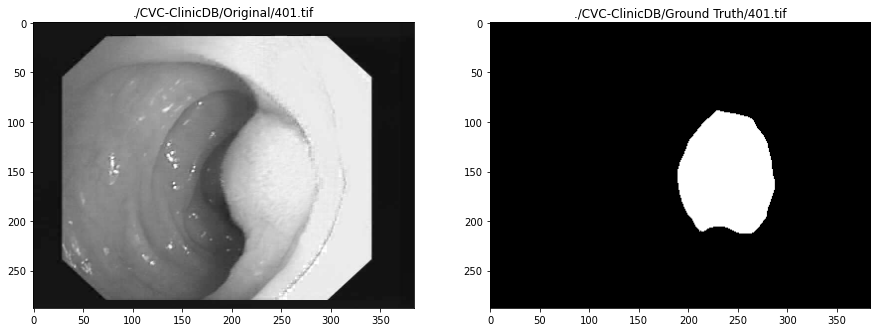

In [17]:

mypath = 'CVC-ClinicDB/Ground Truth/'
onlyfiles = [f.split('.')[0] for f in listdir(mypath) if isfile(join(mypath, f))]

#/content/CVC-ClinicDB/Original
def draw_plots(idx):
    fig, ax = plt.subplots(1, 2, figsize=(15,15))
    mask = cv2.imread(f'./CVC-ClinicDB/Ground Truth/{idx}.tif')
    original = cv2.imread(f'./CVC-ClinicDB/Original/{idx}.tif')
    ax[0].imshow(original)
    ax[0].set_title(f'./CVC-ClinicDB/Original/{idx}.tif')
    ax[1].imshow(mask)
    ax[1].set_title(f'./CVC-ClinicDB/Ground Truth/{idx}.tif')
    plt.show()

draw_plots(onlyfiles[3])

In [31]:
image_size = (352, 352)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
split_size=0.1
BATCH_SIZE=16
root_path = 'CVC-ClinicDB/'
img_root = join(root_path, 'Original')
msk_root = join(root_path, 'Ground Truth')
image_names = [f for f in listdir(img_root) if isfile(join(img_root, f))]
masks_names = [f for f in listdir(msk_root) if isfile(join(msk_root, f))]
if set(image_names) != set(masks_names):
    raise ValueError('There are differences in masks and images')


class PolypDataset(Dataset):
  def __init__(self, root_path, image_names, img_transforms, mask_transforms):
    self.root_path = root_path
    self.img_root = join(root_path, 'Original')
    self.msk_root = join(root_path, 'Ground Truth')
    self.image_names = image_names
    self.img_transforms = img_transforms
    self.mask_transforms = mask_transforms

  def __len__(self):
    return len(self.image_names)

  def __getitem__(self, item):
    image = cv2.imread(join(self.img_root, self.image_names[item]))#we use cv2 because PIL didnt load the image and we convert later to PIL image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image) #Converting CV2 to PIL
    mask = cv2.imread(join(self.msk_root, self.image_names[item])) #we use cv2 because PIL didnt load the image and we convert later to PIL image
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask = Image.fromarray(mask) #we use cv2 because PIL didnt load the image and we convert later to PIL image
    transformed_image = self.img_transforms(image)
    transformed_mask = self.mask_transforms(mask)
    return transformed_image , transformed_mask


train_images, valid_images  = train_test_split(image_names,
                                               test_size=split_size,
                                               random_state = 42)

train_images, test_images = train_test_split(train_images,
                                             test_size=split_size,
                                             random_state = 42)

# Train dataset
train_transform_images = transforms.Compose([
                                      transforms.Resize(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)])
train_transform_masks = transforms.Compose([
                                      transforms.Resize(image_size),
                                      transforms.ToTensor()])
train_dataset = PolypDataset(root_path,
                             train_images,
                             train_transform_images,
                             train_transform_masks)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                              shuffle=True, num_workers=1, pin_memory=True)


# Valid dataset
valid_transform_images = transforms.Compose([
                                      transforms.Resize(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)])
valid_transform_masks = transforms.Compose([
                                      transforms.Resize(image_size),
                                      transforms.ToTensor()])
valid_dataset = PolypDataset(root_path,
                             valid_images,
                             valid_transform_images,
                             valid_transform_masks)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, 
                              shuffle=False, num_workers=1, pin_memory=True)


# Test dataset
test_transform_images = transforms.Compose([
                                      transforms.Resize(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)])
test_transform_masks = transforms.Compose([
                                      transforms.Resize(image_size),
                                      transforms.ToTensor()])
test_dataset = PolypDataset(root_path,
                            test_images,
                            test_transform_images,
                            test_transform_masks)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, 
                             shuffle=False, num_workers=1, pin_memory=True)

# Model PraNet

In [ ]:
class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x


class RFB_modified(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(RFB_modified, self).__init__()
        self.relu = nn.ReLU(True)
        self.branch0 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
        )
        self.branch1 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 3), padding=(0, 1)),
            BasicConv2d(out_channel, out_channel, kernel_size=(3, 1), padding=(1, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=3, dilation=3)
        )
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 5), padding=(0, 2)),
            BasicConv2d(out_channel, out_channel, kernel_size=(5, 1), padding=(2, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=5, dilation=5)
        )
        self.branch3 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(out_channel, out_channel, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=7, dilation=7)
        )
        self.conv_cat = BasicConv2d(4*out_channel, out_channel, 3, padding=1)
        self.conv_res = BasicConv2d(in_channel, out_channel, 1)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = self.conv_cat(torch.cat((x0, x1, x2, x3), 1))

        x = self.relu(x_cat + self.conv_res(x))
        return x


class aggregation(nn.Module):
    # dense aggregation, it can be replaced by other aggregation previous, such as DSS, amulet, and so on.
    # used after MSF
    def __init__(self, channel):
        super(aggregation, self).__init__()
        self.relu = nn.ReLU(True)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_upsample1 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample2 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample3 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample4 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample5 = BasicConv2d(2*channel, 2*channel, 3, padding=1)

        self.conv_concat2 = BasicConv2d(2*channel, 2*channel, 3, padding=1)
        self.conv_concat3 = BasicConv2d(3*channel, 3*channel, 3, padding=1)
        self.conv4 = BasicConv2d(3*channel, 3*channel, 3, padding=1)
        self.conv5 = nn.Conv2d(3*channel, 1, 1)

    def forward(self, x1, x2, x3):
        x1_1 = x1
        x2_1 = self.conv_upsample1(self.upsample(x1)) * x2
        x3_1 = self.conv_upsample2(self.upsample(self.upsample(x1))) \
               * self.conv_upsample3(self.upsample(x2)) * x3

        x2_2 = torch.cat((x2_1, self.conv_upsample4(self.upsample(x1_1))), 1)
        x2_2 = self.conv_concat2(x2_2)

        x3_2 = torch.cat((x3_1, self.conv_upsample5(self.upsample(x2_2))), 1)
        x3_2 = self.conv_concat3(x3_2)

        x = self.conv4(x3_2)
        x = self.conv5(x)

        return x

In [ ]:
class PraNet(nn.Module):
    # res2net based encoder decoder
    def __init__(self, channel=32):
        super(PraNet, self).__init__()
        # ---- ResNet Backbone ----
        self.resnet = res2net50_v1b_26w_4s(pretrained=True).requires_grad_(False)
        # ---- Receptive Field Block like module ----
        self.rfb2_1 = RFB_modified(512, channel)
        self.rfb3_1 = RFB_modified(1024, channel)
        self.rfb4_1 = RFB_modified(2048, channel)
        # ---- Partial Decoder ----
        self.agg1 = aggregation(channel)
        # ---- reverse attention branch 4 ----
        self.ra4_conv1 = BasicConv2d(2048, 256, kernel_size=1)
        self.ra4_conv2 = BasicConv2d(256, 256, kernel_size=5, padding=2)
        self.ra4_conv3 = BasicConv2d(256, 256, kernel_size=5, padding=2)
        self.ra4_conv4 = BasicConv2d(256, 256, kernel_size=5, padding=2)
        self.ra4_conv5 = BasicConv2d(256, 1, kernel_size=1)
        # ---- reverse attention branch 3 ----
        self.ra3_conv1 = BasicConv2d(1024, 64, kernel_size=1)
        self.ra3_conv2 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.ra3_conv3 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.ra3_conv4 = BasicConv2d(64, 1, kernel_size=3, padding=1)
        # ---- reverse attention branch 2 ----
        self.ra2_conv1 = BasicConv2d(512, 64, kernel_size=1)
        self.ra2_conv2 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.ra2_conv3 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.ra2_conv4 = BasicConv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)      # bs, 64, 88, 88
        # ---- low-level features ----
        x1 = self.resnet.layer1(x)      # bs, 256, 88, 88
        x2 = self.resnet.layer2(x1)     # bs, 512, 44, 44

        x3 = self.resnet.layer3(x2)     # bs, 1024, 22, 22
        x4 = self.resnet.layer4(x3)     # bs, 2048, 11, 11
        x2_rfb = self.rfb2_1(x2)        # channel -> 32
        x3_rfb = self.rfb3_1(x3)        # channel -> 32
        x4_rfb = self.rfb4_1(x4)        # channel -> 32

        ra5_feat = self.agg1(x4_rfb, x3_rfb, x2_rfb)
        lateral_map_5 = F.interpolate(ra5_feat, scale_factor=8, mode='bilinear')    # NOTES: Sup-1 (bs, 1, 44, 44) -> (bs, 1, 352, 352)

        # ---- reverse attention branch_4 ----
        crop_4 = F.interpolate(ra5_feat, scale_factor=0.25, mode='bilinear')
        x = -1*(torch.sigmoid(crop_4)) + 1
        x = x.expand(-1, 2048, -1, -1).mul(x4)
        x = self.ra4_conv1(x)
        x = F.relu(self.ra4_conv2(x))
        x = F.relu(self.ra4_conv3(x))
        x = F.relu(self.ra4_conv4(x))
        ra4_feat = self.ra4_conv5(x)
        x = ra4_feat + crop_4
        lateral_map_4 = F.interpolate(x, scale_factor=32, mode='bilinear')  # NOTES: Sup-2 (bs, 1, 11, 11) -> (bs, 1, 352, 352)

        # ---- reverse attention branch_3 ----
        crop_3 = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = -1*(torch.sigmoid(crop_3)) + 1
        x = x.expand(-1, 1024, -1, -1).mul(x3)
        x = self.ra3_conv1(x)
        x = F.relu(self.ra3_conv2(x))
        x = F.relu(self.ra3_conv3(x))
        ra3_feat = self.ra3_conv4(x)
        x = ra3_feat + crop_3
        lateral_map_3 = F.interpolate(x, scale_factor=16, mode='bilinear')  # NOTES: Sup-3 (bs, 1, 22, 22) -> (bs, 1, 352, 352)

        # ---- reverse attention branch_2 ----
        crop_2 = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = -1*(torch.sigmoid(crop_2)) + 1
        x = x.expand(-1, 512, -1, -1).mul(x2)
        x = self.ra2_conv1(x)
        x = F.relu(self.ra2_conv2(x))
        x = F.relu(self.ra2_conv3(x))
        ra2_feat = self.ra2_conv4(x)
        x = ra2_feat + crop_2
        lateral_map_2 = F.interpolate(x, scale_factor=8, mode='bilinear')   # NOTES: Sup-4 (bs, 1, 44, 44) -> (bs, 1, 352, 352)

        return lateral_map_5, lateral_map_4, lateral_map_3, lateral_map_2


In [ ]:
ras = PraNet().cuda()
input_tensor = torch.randn(1, 3, 352, 352).cuda()
out = ras(input_tensor)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


# Train Loop

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
!pip install thop

In [ ]:
import torch
import numpy as np
from thop import profile
from thop import clever_format


def clip_gradient(optimizer, grad_clip):
    """
    For calibrating misalignment gradient via cliping gradient technique
    :param optimizer:
    :param grad_clip:
    :return:
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)


def adjust_lr(optimizer, init_lr, epoch, decay_rate=0.1, decay_epoch=30):
    decay = decay_rate ** (epoch // decay_epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] *= decay


class AvgMeter(object):
    def __init__(self, num=40):
        self.num = num
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.losses = []

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        self.losses.append(val)

    def show(self):
        return torch.mean(torch.stack(self.losses[np.maximum(len(self.losses)-self.num, 0):]))


def CalParams(model, input_tensor):
    """
    Usage:
        Calculate Params and FLOPs via [THOP](https://github.com/Lyken17/pytorch-OpCounter)
    Necessarity:
        from thop import profile
        from thop import clever_format
    :param model:
    :param input_tensor:
    :return:
    """
    flops, params = profile(model, inputs=(input_tensor,))
    flops, params = clever_format([flops, params], "%.3f")
    print('[Statistics Information]\nFLOPs: {}\nParams: {}'.format(flops, params))

In [ ]:
import torch
from torch.autograd import Variable
import os
import argparse
from datetime import datetime
import torch.nn.functional as F


def structure_loss(pred, mask):
    weit = 1 + 5*torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15) - mask)
    wbce = F.binary_cross_entropy_with_logits(pred, mask, reduce='none')
    wbce = (weit*wbce).sum(dim=(2, 3)) / weit.sum(dim=(2, 3))

    pred = torch.sigmoid(pred)
    inter = ((pred * mask)*weit).sum(dim=(2, 3))
    union = ((pred + mask)*weit).sum(dim=(2, 3))
    wiou = 1 - (inter + 1)/(union - inter+1)
    return (wbce + wiou).mean()


def train(train_loader, model, optimizer, epoch):
    model.train()
    # ---- multi-scale training ----
    size_rates = [0.75, 1, 1.25]
    loss_record2, loss_record3, loss_record4, loss_record5 = AvgMeter(), AvgMeter(), AvgMeter(), AvgMeter()
    for i, pack in enumerate(train_loader, start=1):
        for rate in size_rates:
            optimizer.zero_grad()
            # ---- data prepare ----
            images, gts = pack
            images = Variable(images).cuda()
            gts = Variable(gts).cuda()
            # ---- rescale ----
            trainsize = int(round(opt.trainsize*rate/32)*32)
            if rate != 1:
                images = F.upsample(images, size=(trainsize, trainsize), mode='bilinear', align_corners=True)
                gts = F.upsample(gts, size=(trainsize, trainsize), mode='bilinear', align_corners=True)
            # ---- forward ----
            lateral_map_5, lateral_map_4, lateral_map_3, lateral_map_2 = model(images)
            # ---- loss function ----
            loss5 = structure_loss(lateral_map_5, gts)
            loss4 = structure_loss(lateral_map_4, gts)
            loss3 = structure_loss(lateral_map_3, gts)
            loss2 = structure_loss(lateral_map_2, gts)
            loss = loss2 + loss3 + loss4 + loss5    # TODO: try different weights for loss
            # ---- backward ----
            loss.backward()
            clip_gradient(optimizer, opt.clip)
            optimizer.step()
            # ---- recording loss ----
            if rate == 1:
                loss_record2.update(loss2.data, opt.batchsize)
                loss_record3.update(loss3.data, opt.batchsize)
                loss_record4.update(loss4.data, opt.batchsize)
                loss_record5.update(loss5.data, opt.batchsize)
        # ---- train visualization ----
        if i % 20 == 0 or i == total_step:
            print('{} Epoch [{:03d}/{:03d}], Step [{:04d}/{:04d}], '
                  '[lateral-2: {:.4f}, lateral-3: {:0.4f}, lateral-4: {:0.4f}, lateral-5: {:0.4f}]'.
                  format(datetime.now(), epoch, opt.epoch, i, total_step,
                         loss_record2.show(), loss_record3.show(), loss_record4.show(), loss_record5.show()))
    save_path = 'snapshots/{}/'.format(opt.train_save)
    os.makedirs(save_path, exist_ok=True)
    if (epoch+1) % 10 == 0:
        torch.save(model.state_dict(), save_path + 'PraNet-%d.pth' % epoch)
        print('[Saving Snapshot:]', save_path + 'PraNet-%d.pth'% epoch)

'''
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--epoch', type=int,
                        default=20, help='epoch number')
    parser.add_argument('--lr', type=float,
                        default=1e-4, help='learning rate')
    parser.add_argument('--batchsize', type=int,
                        default=16, help='training batch size')
    parser.add_argument('--trainsize', type=int,
                        default=352, help='training dataset size')
    parser.add_argument('--clip', type=float,
                        default=0.5, help='gradient clipping margin')
    parser.add_argument('--decay_rate', type=float,
                        default=0.1, help='decay rate of learning rate')
    parser.add_argument('--decay_epoch', type=int,
                        default=50, help='every n epochs decay learning rate')
    parser.add_argument('--train_path', type=str,
                        default='./data/TrainDataset', help='path to train dataset')
    parser.add_argument('--train_save', type=str,
                        default='PraNet_Res2Net')
    opt = parser.parse_args()

    # ---- build models ----
    # torch.cuda.set_device(0)  # set your gpu device
    model = PraNet().cuda()

    # ---- flops and params ----
    # from utils.utils import CalParams
    # x = torch.randn(1, 3, 352, 352).cuda()
    # CalParams(lib, x)

    params = model.parameters()
    optimizer = torch.optim.Adam(params, opt.lr)

    image_root = '{}/images/'.format(opt.train_path)
    gt_root = '{}/masks/'.format(opt.train_path)

    train_loader = get_loader(image_root, gt_root, batchsize=opt.batchsize, trainsize=opt.trainsize)
    total_step = len(train_loader)

    print("#"*20, "Start Training", "#"*20)

    for epoch in range(1, opt.epoch):
        adjust_lr(optimizer, opt.lr, epoch, opt.decay_rate, opt.decay_epoch)
        train(train_loader, model, optimizer, epoch)
'''

usage: ipykernel_launcher.py [-h] [--epoch EPOCH] [--lr LR]
                             [--batchsize BATCHSIZE] [--trainsize TRAINSIZE]
                             [--clip CLIP] [--decay_rate DECAY_RATE]
                             [--decay_epoch DECAY_EPOCH]
                             [--train_path TRAIN_PATH]
                             [--train_save TRAIN_SAVE]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-b3596e1b-dcf2-43b0-b405-f7e2a31ba498.json


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
